<a href="https://colab.research.google.com/github/justcme/PerformanceSpecs/blob/main/N_Replicates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Ignore bias

* Analytical replicates: Add CV serially and mean values after each. One cross-tabulation at the end.

* Sample replicates: Add BVCV serially and mean values after each. One cross-tabulation at the end.

#SETUP

###Directory

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Colab Notebooks/LipidPerf')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###Imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

###Data

In [ ]:
df_base = pd.read_csv('from_Pandas/Base/df_base.csv')
df0 = pd.read_csv('from_Pandas/Base/df0.csv')
TAE = pd.read_csv('from_Pandas/Base/TAE_df.csv', index_col=0)

In [ ]:
df9 = df_base.loc[:,['ID', 'age', 'HDL', 'TC', 'TG', 'dLDL', 'HDL_CV0', 'CTotalChol', 'CAgeTotalChol', 'CHDLChol', 'CAgeHDLChol', 'S10', 'MeanTerms', 'interum_sum']]
age = df9.loc[:,'age']

# FUNCTIONS

##1. Add Variability

In [ ]:
def AddVarGen(df, parameters, PB, variability_types, replicate):
  """Adds given error types sequentially to given parameters.
  Number of Seeds required for RandomState generation = number of parameters*number of replicates.
  Seeds array should be created before calling function, and saved for validation of analysis."""

  newdf = df.copy()
  lp = len(parameters)
  lv = len(variability_types)

  for n,p in enumerate(parameters):
    newdf.loc[:,f'{p}_new'] = newdf.loc[:,p]

    for k,e in enumerate(variability_types):
      pos = lp*lv*replicate + (lv*n +k)

      if lv == 1:
        a = np.random.RandomState(Seeds1[pos])
      else:
        a = np.random.RandomState(Seeds2[pos])
        
      if p == 'HDL' and e == 'CV':
        V = newdf.loc[:,f'HDL_CV{PB}']
      else:
        V = TAE.loc[p,e]

      newdf.loc[:,f'{p}_new'] = norm.ppf(a.uniform(1e-16,0.9999999999999999,8506), loc = newdf.loc[:,f'{p}_new'], scale = V*newdf.loc[:,f'{p}_new']).astype('int')

    #To deal with values <0, make them = 1
    newdf.loc[:,f'{p}_new'] = np.select(condlist = [newdf.loc[:,f'{p}_new']<0, newdf.loc[:,f'{p}_new']>=0],
                                        choicelist = [1, newdf.loc[:,f'{p}_new']],
                                        default = np.nan)


  return newdf

In [ ]:
def MeanOfReps(df, parameters, replicate):
  """Finds the mean value of replicates of each measurement."""

  newdf = df.copy()
  r = replicate+1

  for p in parameters:
    newdf[f'{p}_mean'] = round((newdf.loc[:,f'{p}_mean']*replicate + newdf.loc[:,f'{p}_new'])/r, ndigits = None)
 
  return newdf

## 2. Calculate and create columns for variable PCE terms and sum them

In [ ]:
def AddSum3(df):
  newdf = df.copy()

  TC = newdf.loc[:,'TC_mean']
  HDL = newdf.loc[:,'HDL_mean']

  vcoeffs = ['CTotalChol','CAgeTotalChol','CHDLChol','CAgeHDLChol']

  var_list = [np.log(TC), np.log(age)*np.log(TC), np.log(HDL), np.log(age)*np.log(HDL)]

  newdf.loc[:,'add_sum']=0

  for t,k in zip(vcoeffs, var_list):
    newdf.loc[:,'add_sum'] += df[t]*k
  
  return newdf

## 3. Pooled Cohort Equation (PCE)

In [ ]:
def PCEcalc2(df):
  newdf = df.copy()

  newdf['terms'] = df['interum_sum'] + df['add_sum']
  newdf['PCE'] = 100*(1 - newdf['S10'] ** (np.e ** (newdf['terms'] - newdf['MeanTerms'])))
  
  return newdf

## 4. Calculate LDL-C and NHDL-C

In [ ]:
def BLipCalc3(df, TC, HDL, TG):
  """This function calculates LDL-C using the Friedewald equation, and non-HDL-C."""

  newdf = df.copy()
  TC = newdf.loc[:,TC]
  HDL = newdf.loc[:, HDL]
  TG = newdf.loc[:, TG]

  newdf['NHDL'] = TC - HDL
  NHDL = newdf['NHDL']

  #To calculate LDL-C: where TG >400, use Sampson equation
  newdf['cLDL'] = np.select(condlist = [TG<=400, TG>400],
                            choicelist = [TC - HDL - TG/5, TC/0.948 - HDL/0.971 - (TG/8.56 + (TG*NHDL)/2140 - (TG**2)/16100) - 9.44],
                            default = np.nan)
  

  return newdf

## 5. Risk Group Determination

In [ ]:
def Groups3(df, TG, BLipType):
  """This function determines the Risk Group (A-D) based on LDL-C and non-HDL-C and creates a column for each."""

  newdf = df.copy()

  TG = newdf.loc[:, TG]
  PCE = newdf.loc[:,'PCE']

  if BLipType == 'cLDL' or BLipType == 'dLDL_mean':
    LDL = newdf.loc[:,BLipType]
    newdf.loc[:,'Lgroup'] = np.nan
    newdf.loc[:,'Lgroup'] = np.select(condlist=[(PCE<7.5) | (LDL<70),
                                                (PCE >=20) | (LDL >=190),
                                                (LDL >=70) & (LDL <160) & (TG <175),
                                                (LDL >=160) | (TG >=175)],
                                      choicelist=['A','D', 'B', 'C'],
                                      default=np.nan)
  else:
    NHDL = newdf.loc[:,'NHDL']
    newdf.loc[:,'Ngroup'] = np.nan
    newdf.loc[:,'Ngroup'] = np.select(condlist=[(PCE<7.5) | (NHDL<90),
                                                (PCE >=20) | (NHDL >=220),
                                                (NHDL >=90) & (NHDL <190) & (TG <175),
                                                (NHDL >=190) | (TG >=175)],
                                      choicelist=['A','D', 'B', 'C'],
                                      default=np.nan)

  return newdf

## 6. Cross-Tabulate

In [ ]:
def XT3(df, BLipType):

  if BLipType == 'cLDL' or BLipType == 'dLDL_mean':
    grouptype = 'Lgroup'
  else:
    grouptype = 'Ngroup'

  XTB = pd.DataFrame(pd.crosstab(df[grouptype], df0[grouptype], normalize = True))
  TotalReClass = round(100*(1-XTB.loc['A','A']-XTB.loc['B','B']-XTB.loc['C','C']-XTB.loc['D','D']), ndigits=1)

  return TotalReClass

## 7. One Function to Call them All

In [ ]:
def allcall(basedf, parameters, PB, error_types, replicates):
  rep_d = {}
  rep_d['Replicate'] = np.arange(1,replicates+1)
  for BLipType in ['cLDL','dLDL_mean','NHDL']:
    rep_d[BLipType] = []

  df = basedf.copy()
  for param in parameters:
    df.loc[:,f'{param}_mean'] = df.loc[:,'ID']      #sanity test

  if 'BV' in error_types:
    df = df
  else:
    for p, pos in zip(parameters, [0,2,4,6]):
      a = np.random.RandomState(Seeds2[pos])
      V = TAE.loc[p,'BV']
      df.loc[:,f'{p}_new'] = norm.ppf(a.uniform(1e-16,0.9999999999999999,8506), loc = df.loc[:,p], scale = V*df.loc[:,p]).astype('int')
      df = df.rename(columns = {p:f'{p}_old', f'{p}_new':p})

  for m in range(replicates):
    df = AddVarGen(df, parameters, PB, error_types, m)
    df = MeanOfReps(df, parameters, m)
    df = AddSum3(df)
    df = PCEcalc2(df)
    df = BLipCalc3(df, 'TC_mean', 'HDL_mean', 'TG_mean')
    for BLipType in ['cLDL','dLDL_mean','NHDL']:
      df = Groups3(df, 'TG_mean', BLipType)
      rep_d[BLipType].append(XT3(df, BLipType))
  rep_df = pd.DataFrame(rep_d)
  return rep_df

# CALL FUNCTIONS

In [ ]:
#np.random.randint(0,500,80)
#Total number is (# of parameters) x (# of variability types) x (# of replicates)

In [ ]:
Seeds2 = [399, 195, 127, 132, 278, 443,  69, 442, 424,   3, 484, 213, 328,
       417, 380, 436, 419, 323, 379, 362, 195, 407, 214,  27, 317, 339,
       487, 290, 117, 325, 159, 226, 269, 494, 418, 472, 149,  71, 156,
       172, 387, 208, 247, 209, 386, 373, 434, 421,  87, 305, 423, 466,
       285, 498, 345, 395, 247, 310, 207,  17, 384, 362, 198, 360, 342,
       422, 327, 315, 126, 337, 404, 109,  82, 378, 405,  67, 476, 129,
       401, 311]

In [ ]:
#Seeds1 = Seeds[1::2]
Seeds1 = [195, 132, 443, 442, 3, 213, 417, 436, 323, 362, 407, 27,
 339, 290, 325, 226, 494, 472, 71, 172, 208, 209, 373, 421, 305, 466,
 498, 395, 310, 17, 362, 360, 422, 315, 337, 109, 378, 67, 129, 311]

In [ ]:
params = ['TC', 'HDL', 'TG', 'dLDL']

In [ ]:
AnalyticalReps = allcall(df9, params, 0, ['CV'], 10)
AnalyticalReps = AnalyticalReps.rename(columns = {'dLDL_mean':'dLDL-C', 'cLDL': 'cLDL-C', 'NHDL':'nonHDL-C'})
AnalyticalReps

,Replicate,cLDL-C,dLDL-C,nonHDL-C
0,1,7.1,6.7,6.5
1,2,6.7,6.2,6.0
2,3,6.5,6.1,6.1
3,4,6.5,6.1,6.0
4,5,6.4,6.0,5.9
5,6,6.5,6.1,5.9
6,7,6.4,6.1,5.9
7,8,6.4,6.0,6.0
8,9,6.4,6.0,5.9
9,10,6.3,5.9,5.9


In [ ]:
SampleReps = allcall(df9, params, 0, ['BV', 'CV'], 10)
SampleReps = SampleReps.rename(columns = {'dLDL_mean':'dLDL-C', 'cLDL': 'cLDL-C', 'NHDL':'nonHDL-C'})
SampleReps

,Replicate,cLDL-C,dLDL-C,nonHDL-C
0,1,7.1,6.7,6.5
1,2,5.4,4.8,4.6
2,3,4.4,3.9,3.8
3,4,3.9,3.6,3.6
4,5,3.8,3.3,3.3
5,6,3.7,3.4,3.2
6,7,3.5,3.1,2.9
7,8,3.3,3.0,2.8
8,9,3.0,2.8,2.5
9,10,2.9,2.6,2.4


# PLOT DATA

In [ ]:
AnalyticalReps.head()

,Replicate,cLDL-C,dLDL-C,nonHDL-C
0,1,7.1,6.7,6.5
1,2,6.7,6.2,6.0
2,3,6.5,6.1,6.1
3,4,6.5,6.1,6.0
4,5,6.4,6.0,5.9


In [ ]:
AnRepPlot = AnalyticalReps.melt(id_vars = 'Replicate',value_vars = ['cLDL-C','dLDL-C','nonHDL-C'],var_name = 'BLip',value_name='value', ignore_index=True)
AnRepPlot.head()

,Replicate,BLip,value
0,1,cLDL-C,7.1
1,2,cLDL-C,6.7
2,3,cLDL-C,6.5
3,4,cLDL-C,6.5
4,5,cLDL-C,6.4


In [ ]:
SamRepPlot = SampleReps.melt(id_vars = 'Replicate',value_vars = ['cLDL-C','dLDL-C','nonHDL-C'],var_name = 'BLip',value_name='value', ignore_index=True)
SamRepPlot.head(30)

,Replicate,BLip,value
0,1,cLDL-C,7.1
1,2,cLDL-C,5.4
2,3,cLDL-C,4.4
3,4,cLDL-C,3.9
4,5,cLDL-C,3.8
5,6,cLDL-C,3.7
6,7,cLDL-C,3.5
7,8,cLDL-C,3.3
8,9,cLDL-C,3.0
9,10,cLDL-C,2.9


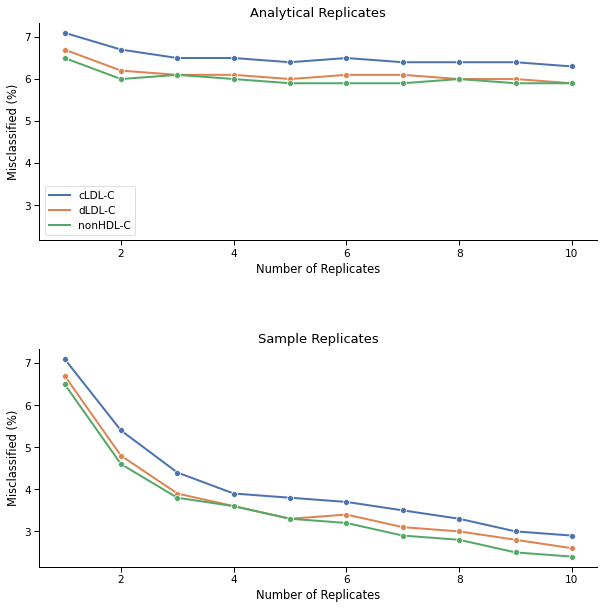

In [ ]:
fig, ((ax1),(ax2)) = plt.subplots(nrows = 2, ncols = 1, sharex=False, sharey = True, figsize=(10,10), gridspec_kw={'wspace': 0.3, 'hspace': 0.5})
#fig.suptitle('Effect of Analytical and Sample Replicates on Reclassification by cLDL-C, dLDL-C and nonHDL-C', y= 0.98, fontsize=15)

sns.set_context('paper', font_scale=1.2, rc={"lines.linewidth": 2, "lines.markersize":6})

#Analytical Replicates
sns.lineplot(data = AnRepPlot, x='Replicate', y='value', ax=ax1, palette='deep', hue = 'BLip', marker = 'o')

#Sample Replicates
sns.lineplot(data = SamRepPlot, x='Replicate', y='value', ax=ax2, palette='deep', hue = 'BLip', marker = 'o', legend = False)

sns.despine()
ax1.legend(labels=None)

for ax,t in zip([ax1, ax2], ['Analytical Replicates', 'Sample Replicates']):
  ax.set(xlabel = 'Number of Replicates', ylabel ='Misclassified (%)')
  ax.set_title(t, fontsize = 13)


In [ ]:
fig.savefig('from_Pandas/Figures/PNG/Replicates.png', dpi = 600)
fig.savefig('from_Pandas/Figures/Replicates.jpg', dpi = 600)